<a href="https://colab.research.google.com/github/aimbsg/EVA4_S11/blob/master/EVA4_S11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

S11 Model

PrepLayer - Conv 3x3 s1, p1) >> BN >> RELU [64k]

Layer1 -

X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k]

R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k] 

Add(X, R1)

Layer 2 -

Conv 3x3 [256k]

MaxPooling2D

BN

ReLU

Layer 3 -

X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k]

R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k]

Add(X, R2)

MaxPooling with Kernel Size 4

FC Layer 

SoftMax

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
!pip install -U git+https://github.com/albu/albumentations

In [2]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/EVA4_S11_CIFAR10_OCP/'

/content/gdrive/My Drive/EVA4_S11_CIFAR10_OCP


In [0]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import data_loader as train_test_loader
import visualize_images as show_images
import backbone as model
import train_test
import model_evaluator as evaluate
from transforms_albumentation import AlbumentationTransforms
from gradcam import GradCAM,visualize_cam

In [0]:
import albumentations as A

channel_means = (0.5, 0.5, 0.5)
channel_stdevs = (0.5, 0.5, 0.5)
train_transform = AlbumentationTransforms([
                                       A.PadIfNeeded(min_height=36, min_width=36, always_apply=True),
                                       A.RandomCrop(32,32),
                                       A.HorizontalFlip(),
                                       A.Normalize(mean=channel_means, std=channel_stdevs),
                                       A.Cutout(num_holes=1, max_h_size=8,max_w_size = 8,p=1),
                                       ])
# Test Phase transformations
test_transform = AlbumentationTransforms([A.Normalize(mean=channel_means, std=channel_stdevs),])

In [6]:
classes, trainloader, testloader = train_test_loader.load(train_transform,test_transform)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


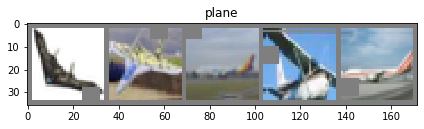

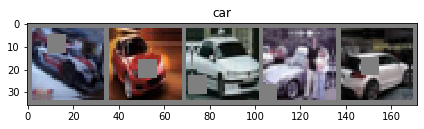

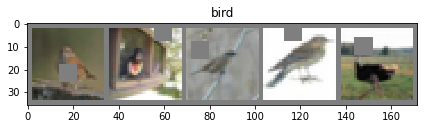

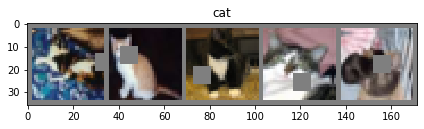

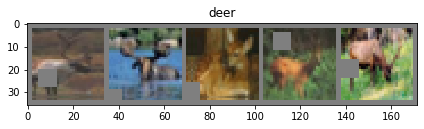

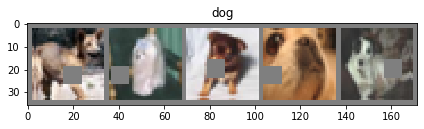

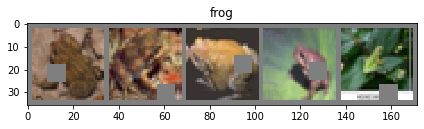

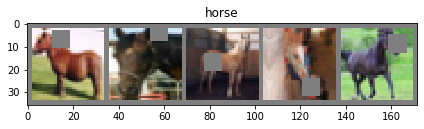

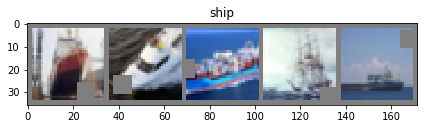

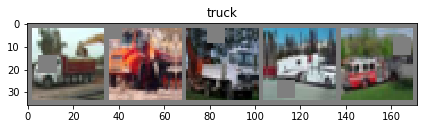

In [0]:
show_images.show_train_data(trainloader, classes)

In [7]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.Custom_ResNet().to(device)
summary(model, input_size=(3,32,32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

In [0]:
#@title LR finder package installer
!pip install torch-lr-finder -v --global-option="amp"

In [8]:
import torch_lr_finder as lr
import torch.nn as nn
import torch.optim as optim

lr_criterion = nn.CrossEntropyLoss()
lr_optimiser = optim.SGD(model.parameters(), lr=1e-05,momentum=0.9 ,weight_decay = 0.0001)
lr_finder = lr.LRFinder(model, lr_optimiser, lr_criterion, device="cuda")
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=98 ,step_mode="exp") # num_iter = train_size/batch_size i.e 50000/512

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


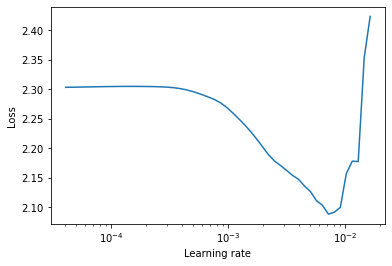

In [9]:
lr_finder.plot()

In [10]:
ideal_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]
ideal_lr

0.007196856730011518

In [0]:
lr_finder.reset()

In [0]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = ideal_lr, momentum = 0.9, weight_decay = 0.005)
scheduler = OneCycleLR(optimizer = optimizer, max_lr = 0.01, total_steps = None, epochs = 24, steps_per_epoch = 2, pct_start = 0.2, anneal_strategy = 'linear', cycle_momentum=False, div_factor = 10, final_div_factor = 1)
# final_div_factor = 1 - Set to 1 to avoid annealing


In [13]:
train_loss = [] 
train_acc = []
test_loss = []
test_acc = []
epochs = 24
best_acc = 89 # save the model only if the accuracy crosses 89% as we already achieved 88% in previous assignment with LR finder. 

for epoch in range(epochs):
     print("Epoch:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
     train_test.train(model, device, trainloader, optimizer, criterion, epoch)     
     scheduler.step()
     test_loss , test_acc = train_test.test(model, device, criterion, testloader)
     train_loss , train_acc = train_test.train_metrics_accumulator(model, device, criterion, trainloader)
    #  scheduler.step(test_loss[-1])
    
     if(test_acc[-1]>best_acc):
       print("...BEST MODEL...")
       best_acc = test_acc[-1]
       torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss[-1],
            }, "/content/gdrive/My Drive/EVA4_S11_CIFAR10_OCP/bestmodel_using_OCP.pt")
       print("Save success...")

  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 1 LR: 0.001


Loss=1.351626992225647 Batch_id=97 Accuracy=39.28: 100%|██████████| 98/98 [00:21<00:00,  4.57it/s]



Test set: Average loss: 0.0027, Accuracy: 5181/10000 (51.81%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 2 LR: 0.002046511627906977


Loss=1.0715376138687134 Batch_id=97 Accuracy=56.22: 100%|██████████| 98/98 [00:20<00:00,  4.67it/s]



Test set: Average loss: 0.0022, Accuracy: 6133/10000 (61.33%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 3 LR: 0.0030930232558139537


Loss=0.9967455267906189 Batch_id=97 Accuracy=64.40: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]



Test set: Average loss: 0.0019, Accuracy: 6594/10000 (65.94%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 4 LR: 0.00413953488372093


Loss=0.6832113265991211 Batch_id=97 Accuracy=70.66: 100%|██████████| 98/98 [00:21<00:00,  4.48it/s]



Test set: Average loss: 0.0016, Accuracy: 7257/10000 (72.57%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 5 LR: 0.005186046511627907


Loss=0.6586498618125916 Batch_id=97 Accuracy=74.41: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]



Test set: Average loss: 0.0015, Accuracy: 7394/10000 (73.94%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 6 LR: 0.006232558139534884


Loss=0.5309688448905945 Batch_id=97 Accuracy=77.71: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]



Test set: Average loss: 0.0013, Accuracy: 7688/10000 (76.88%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 7 LR: 0.00727906976744186


Loss=0.42416414618492126 Batch_id=97 Accuracy=80.20: 100%|██████████| 98/98 [00:21<00:00,  4.55it/s]



Test set: Average loss: 0.0013, Accuracy: 7809/10000 (78.09%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 8 LR: 0.008325581395348837


Loss=0.5729008316993713 Batch_id=97 Accuracy=82.22: 100%|██████████| 98/98 [00:21<00:00,  4.61it/s]



Test set: Average loss: 0.0016, Accuracy: 7349/10000 (73.49%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 9 LR: 0.009372093023255815


Loss=0.4468766748905182 Batch_id=97 Accuracy=83.61: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]



Test set: Average loss: 0.0011, Accuracy: 8172/10000 (81.72%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 10 LR: 0.00990625


Loss=0.38029202818870544 Batch_id=97 Accuracy=85.54: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]



Test set: Average loss: 0.0010, Accuracy: 8183/10000 (81.83%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 11 LR: 0.009671875


Loss=0.42573466897010803 Batch_id=97 Accuracy=87.37: 100%|██████████| 98/98 [00:21<00:00,  4.57it/s]



Test set: Average loss: 0.0010, Accuracy: 8385/10000 (83.85%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 12 LR: 0.0094375


Loss=0.28190386295318604 Batch_id=97 Accuracy=88.52: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]



Test set: Average loss: 0.0009, Accuracy: 8552/10000 (85.52%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 13 LR: 0.009203125000000001


Loss=0.3390583097934723 Batch_id=97 Accuracy=89.94: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]



Test set: Average loss: 0.0009, Accuracy: 8560/10000 (85.60%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 14 LR: 0.008968750000000001


Loss=0.260982871055603 Batch_id=97 Accuracy=90.89: 100%|██████████| 98/98 [00:21<00:00,  4.62it/s]



Test set: Average loss: 0.0008, Accuracy: 8701/10000 (87.01%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 15 LR: 0.008734375


Loss=0.2516319155693054 Batch_id=97 Accuracy=91.39: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]



Test set: Average loss: 0.0009, Accuracy: 8538/10000 (85.38%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 16 LR: 0.0085


Loss=0.20998550951480865 Batch_id=97 Accuracy=92.17: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]



Test set: Average loss: 0.0007, Accuracy: 8776/10000 (87.76%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 17 LR: 0.008265625


Loss=0.18043658137321472 Batch_id=97 Accuracy=93.14: 100%|██████████| 98/98 [00:21<00:00,  4.57it/s]



Test set: Average loss: 0.0009, Accuracy: 8532/10000 (85.32%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 18 LR: 0.00803125


Loss=0.136215478181839 Batch_id=97 Accuracy=93.81: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]



Test set: Average loss: 0.0008, Accuracy: 8752/10000 (87.52%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 19 LR: 0.007796875


Loss=0.16311132907867432 Batch_id=97 Accuracy=94.25: 100%|██████████| 98/98 [00:21<00:00,  4.61it/s]



Test set: Average loss: 0.0007, Accuracy: 8811/10000 (88.11%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 20 LR: 0.0075625


Loss=0.1936977505683899 Batch_id=97 Accuracy=95.01: 100%|██████████| 98/98 [00:21<00:00,  4.56it/s]



Test set: Average loss: 0.0007, Accuracy: 8887/10000 (88.87%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 21 LR: 0.007328125


Loss=0.13565696775913239 Batch_id=97 Accuracy=95.48: 100%|██████████| 98/98 [00:21<00:00,  4.49it/s]



Test set: Average loss: 0.0007, Accuracy: 8849/10000 (88.49%)



  0%|          | 0/98 [00:00<?, ?it/s]

Epoch: 22 LR: 0.00709375


Loss=0.13118602335453033 Batch_id=97 Accuracy=95.79: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]



Test set: Average loss: 0.0007, Accuracy: 8933/10000 (89.33%)

...BEST MODEL...


  0%|          | 0/98 [00:00<?, ?it/s]

Save success...
Epoch: 23 LR: 0.006859375


Loss=0.18141035735607147 Batch_id=97 Accuracy=96.15: 100%|██████████| 98/98 [00:21<00:00,  4.48it/s]



Test set: Average loss: 0.0006, Accuracy: 8951/10000 (89.51%)



  0%|          | 0/98 [00:00<?, ?it/s]

...BEST MODEL...
Save success...
Epoch: 24 LR: 0.006625


Loss=0.15807849168777466 Batch_id=97 Accuracy=96.50: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]



Test set: Average loss: 0.0006, Accuracy: 9040/10000 (90.40%)

...BEST MODEL...
Save success...


In [14]:
evaluate.val_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 90.40 %


In [15]:
evaluate.class_accuracy(model, device, classes, testloader)

Accuracy of plane : 91 %
Accuracy of   car : 96 %
Accuracy of  bird : 84 %
Accuracy of   cat : 84 %
Accuracy of  deer : 89 %
Accuracy of   dog : 81 %
Accuracy of  frog : 92 %
Accuracy of horse : 96 %
Accuracy of  ship : 96 %
Accuracy of truck : 91 %


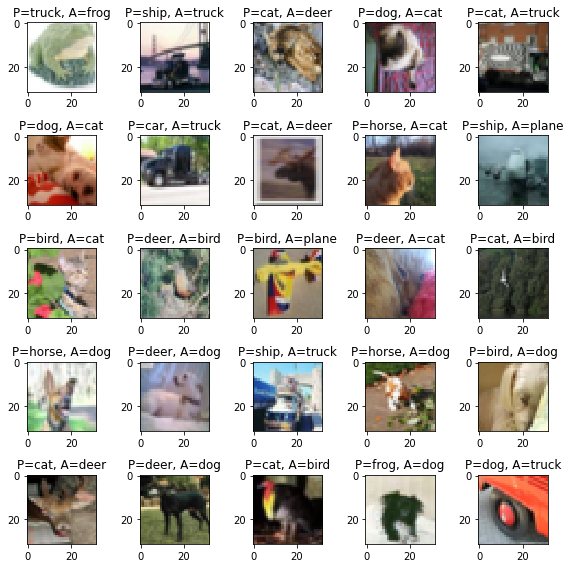

In [16]:
evaluate.view_misclassified_images(model, device, testloader, classes)

Text(0.5, 1.0, 'Test Accuracy')

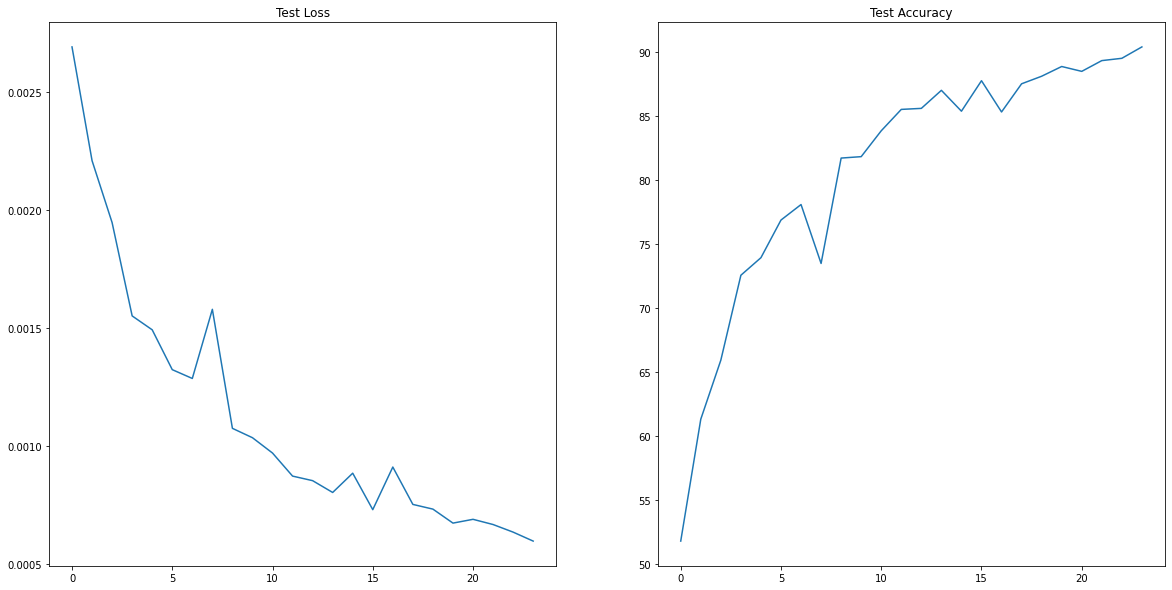

In [17]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(20,10))

axs[0].plot(test_loss)
axs[0].set_title("Test Loss")

axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")

In [0]:
# model = model.ResNet18(dropout=0.1).to(device)
# optimizer = optim.SGD(model.parameters(), lr=Best_lr,momentum=0.9 ,weight_decay = 0.0005)
checkpoint = torch.load("/content/gdrive/My Drive/EVA4_S11_CIFAR10_OCP/bestmodel_using_OCP.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
print("Loaded the best model")

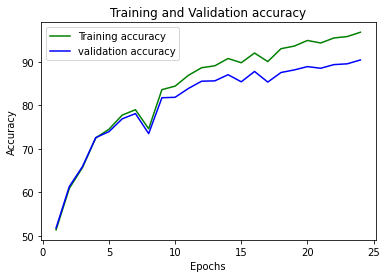

In [18]:
evaluate.plot_train_vs_test_accuracy(epochs, train_acc, test_acc)

Plot cycle LR

In [0]:
iterations = 311
step_size = 100
lr_min = 0.001
lr_max = 0.01

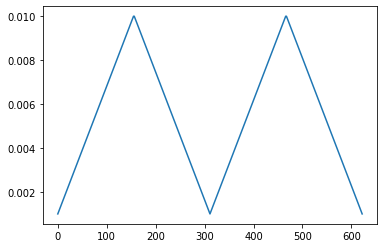

In [21]:
show_images.plot_one_cycle_LR(iterations, step_size, lr_min, lr_max)